<a href="https://colab.research.google.com/github/sofiasilingardi16/Misogyny-Repeated-and-Reposted/blob/main/Coding_SUB_RQ_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers torch torchvision pandas pillow tqdm

import os
import torch
import clip
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, SiglipForImageClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t6gv1b59
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t6gv1b59
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Mount your Drive if you haven't already
from google.colab import drive
drive.mount('/content/drive')

# Define your paths
TSV_PATH = "/content/drive/MyDrive/MA THESIS/CODE FOR THESIS/test.tsv"
IMAGE_DIR = "/content/drive/MyDrive/MA THESIS/test_images"

# Load your data
df = pd.read_csv(TSV_PATH, sep="\t", on_bad_lines='skip')
df = df[df["label"] == 1].reset_index(drop=True)

# Create full image paths
df["image_path_full"] = df["file_name"].apply(lambda f: os.path.join(IMAGE_DIR, f))

Mounted at /content/drive


In [ ]:
# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Load SIGLIP
siglip_model_name = "prithivMLmods/siglip2-x256-explicit-content"
siglip_model = SiglipForImageClassification.from_pretrained(siglip_model_name).to(device)
siglip_processor = AutoImageProcessor.from_pretrained(siglip_model_name, trust_remote_code=True)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.7MiB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
def compute_clip_sim(text, img_path):
    try:
        image = clip_preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        tokens = clip.tokenize([text]).to(device)
        with torch.no_grad():
            img_vec = clip_model.encode_image(image).float()
            txt_vec = clip_model.encode_text(tokens).float()
            img_vec /= img_vec.norm(dim=-1, keepdim=True)
            txt_vec /= txt_vec.norm(dim=-1, keepdim=True)
        return (img_vec @ txt_vec.T).item()
    except Exception as e:
        print(f"[CLIP ERROR] {img_path}: {e}")
        return None

def compute_explicitness(img_path):
    try:
        image = Image.open(img_path).convert("RGB")
        inputs = siglip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = siglip_model(**inputs).logits
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().tolist()
        return probs[3] + probs[4]  # Pornography + Enticing or Sensual
    except Exception as e:
        print(f"[SIGLIP ERROR] {img_path}: {e}")
        return None

In [ ]:
tqdm.pandas()

df["clip_sim"] = df.progress_apply(
    lambda row: compute_clip_sim(row["text"], row["image_path_full"]),
    axis=1
)

df["explicitness_score"] = df.progress_apply(
    lambda row: compute_explicitness(row["image_path_full"]),
    axis=1
)

# Drop rows where processing failed
df_clean = df.dropna(subset=["clip_sim", "explicitness_score"]).reset_index(drop=True)

  0%|          | 0/500 [00:00<?, ?it/s]

[CLIP ERROR] /content/drive/MyDrive/MA THESIS/test_images/15113.jpg: Input FEMINISTS DESTROYING SCALES Anonymous 05/15/15(Fri)06:32:00 No.615722980 >>615723249615723316 >>615723459 >>6157235 >>615722600 Why do they need bats to destroy those scales when they could just step on them? is too long for context length 77
[CLIP ERROR] /content/drive/MyDrive/MA THESIS/test_images/15774.jpg: Input Wohnen > Geschenke Handschuhe für zwei Sich gemeinsam warmhalten und Händchen halten können Paare im Winter mit dem Handschuh-Set aus Wollfilz von Designerin Franziska Holzmann. Bestellbar bei: Ikarus 17,90 € Produkt melden zum Shop THE PERFECT CHRISTMAS PRESENT is too long for context length 77


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
threshold = df_clean["clip_sim"].quantile(0.75)

df_clean["alignment"] = df_clean["clip_sim"].apply(
    lambda x: "amplify" if x >= threshold else "obscure"
)

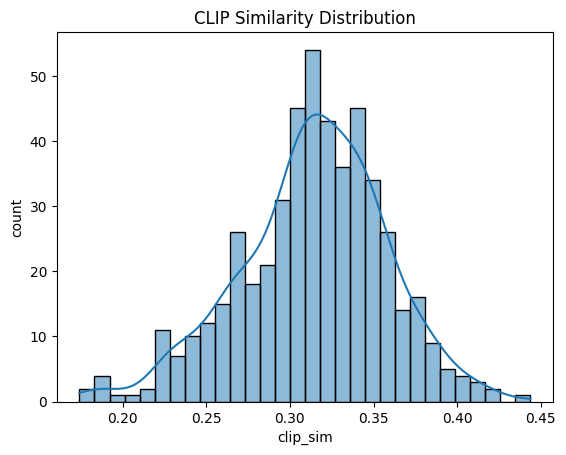

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_clean["clip_sim"], bins=30, kde=True)
plt.title("CLIP Similarity Distribution")
plt.xlabel("clip_sim")
plt.ylabel("count")
plt.show()

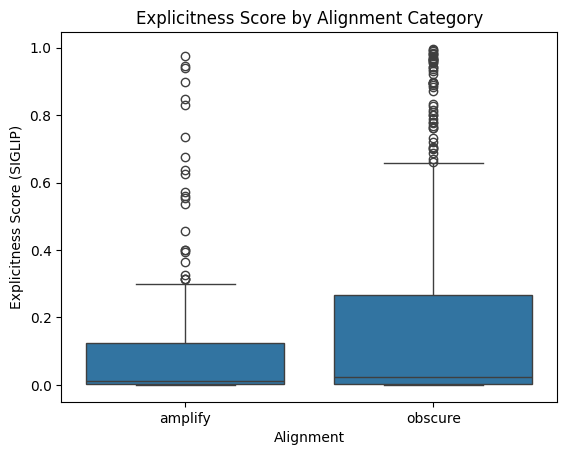

In [ ]:
sns.boxplot(data=df_clean, x="alignment", y="explicitness_score")
plt.title("Explicitness Score by Alignment Category")
plt.xlabel("Alignment")
plt.ylabel("Explicitness Score (SIGLIP)")
plt.show()

In [ ]:
print(df_clean[["clip_sim", "explicitness_score"]].corr())

                    clip_sim  explicitness_score
clip_sim            1.000000           -0.195213
explicitness_score -0.195213            1.000000


In [ ]:
examples = pd.concat([
    df_clean[df_clean["alignment"] == "amplify"].nlargest(2, "clip_sim"),
    df_clean[df_clean["alignment"] == "obscure"].nsmallest(2, "clip_sim")
])

examples[["file_name", "text", "clip_sim", "explicitness_score", "alignment"]].to_csv("manual_examples.csv", index=False)

In [ ]:
print(examples.head())

     file_name  label  shaming  stereotype  objectification  violence  \
283  16078.jpg      1        0           0                1         1   
210  17039.jpg      1        1           1                0         0   
273  16089.jpg      1        0           0                1         0   
347  16038.jpg      1        0           1                1         0   

                                                  text  \
283  MY GIRL NOT ALLOWED TO YAWN WHAT YOU TRYNA DO ...   
210            ERIN BROCKOVICH THE QUEEN OF THE KARENS   
273                   wwwd VACUUM SEALED FOR FRESHNESS   
347  WHEN YOU KNOW IT'S A TRAP BUT YOU CAN'T WAIT T...   

                                       image_path_full  clip_sim  \
283  /content/drive/MyDrive/MA THESIS/test_images/1...  0.443713   
210  /content/drive/MyDrive/MA THESIS/test_images/1...  0.418191   
273  /content/drive/MyDrive/MA THESIS/test_images/1...  0.174234   
347  /content/drive/MyDrive/MA THESIS/test_images/1...  0.178966   

  

In [ ]:
df_clean.to_csv("subrq3_clip_results.csv", index=False)

In [ ]:
# Define your path to Drive
drive_path = "/content/drive/MyDrive/MA THESIS/subrq3_clip_results.csv"

# Save it there
df_clean.to_csv(drive_path, index=False)

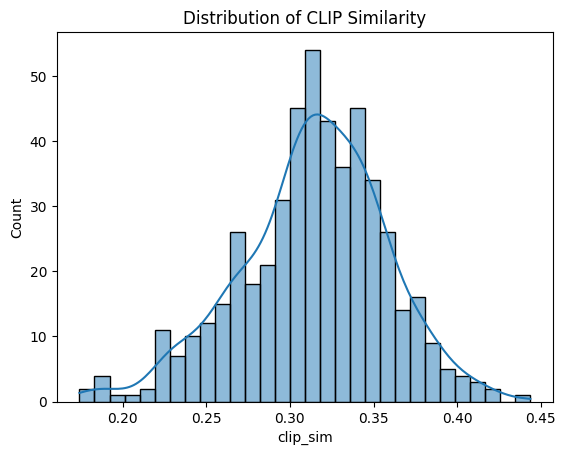

In [ ]:
sns.histplot(df_clean["clip_sim"], bins=30, kde=True)
plt.title("Distribution of CLIP Similarity")
plt.show()

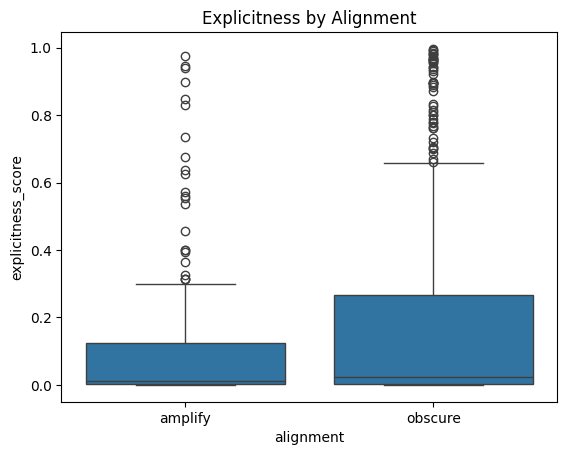

In [ ]:
sns.boxplot(data=df_clean, x="alignment", y="explicitness_score")
plt.title("Explicitness by Alignment")
plt.show()

In [ ]:
df_clean.groupby("alignment")["explicitness_score"].describe()

,count,mean,std,min,25%,50%,75%,max
alignment,,,,,,,,
amplify,125.0,0.135499,0.243761,0.000264,0.002512,0.010240,0.124142,0.974568
obscure,373.0,0.200521,0.303392,0.000074,0.003618,0.024756,0.266181,0.996251


In [ ]:
df_clean[["clip_sim", "explicitness_score"]].corr()

,clip_sim,explicitness_score
clip_sim,1.000000,-0.195213
explicitness_score,-0.195213,1.000000


In [ ]:
save_path = "/content/drive/MyDrive/MA THESIS/manual_examples.csv"

examples[["file_name", "text", "clip_sim", "explicitness_score", "alignment"]].to_csv(save_path, index=False)

In [ ]:
# prompt: how to print manual_examples.csv

import pandas as pd
print(pd.read_csv("manual_examples.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'manual_examples.csv'